<div class="alert alert-block alert-success">
    <h1>Machine Learning -  прогнозирования временных рядов</h1>
</div>

# Задача

Сеть из трех продуктовых магазинов хочет спрогнозировать общий объем выручки сети на январь 2021 года. В качестве данных для построения моделей компания предоставляет данные о выручке за период `2020.05.01 - 2020.12.31`. Прогноз должен быть по дням.

### Как это сделать?

1. Исследуем данные, которые нам предоставили
2. Построим стратегию расчета прогнозной модели
3. Сделаем машин лернинг

### Подготовим нужные библиотеки

In [1]:
# conda install -c conda-forge seaborn
# mamba install -c conda-forge seaborn # если утсановлена mamba - лучше через неё

In [2]:
# устанавливаю в текущую среду
# import sys
# !{sys.executable} -m pip install sklearn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # это библиотека для управления warning'ами — то есть различными предупреждениями
                # ниже мы с помощью нее игнорим лишние предупреждения
                # мы можем это убрать, но где-то всплывали ворнинги, и чтобы они не раздражали и не вызывали вопросов, мы их отключим

warnings.filterwarnings('ignore')

### Графический анализ данных

Для начала посмотрим на данные — какие есть поля, объем данных и т. д.

In [4]:
data_revenue = pd.read_csv('revenue_01.05.2020_31.12.2020.csv') # подключимся к данным

In [5]:
data_revenue.head()

,date,revenue,filial
0,2020-05-01,27913.472202,1
1,2020-05-01,79628.533014,2
2,2020-05-01,106898.121785,3
3,2020-05-02,37477.720561,1
4,2020-05-02,129503.460723,2


In [6]:
data_revenue.shape

(735, 3)

В наших данных есть общая информация о выручке в каждом из трех филиалов за каждый день с 1 мая 2020 по 31 декабря 2020.

Наша задача — спрогнозировать общую выручку по всем трем филиалам, поэтому посмотрим на общие данные.

Возьмем гистограмму, которая отдаст частотность разных показателей выручки. В сам график передадим сгруппированный датасет по датам и выручке, чтобы каждый день встречался единожды и мы считали сумму по трем филиалам.

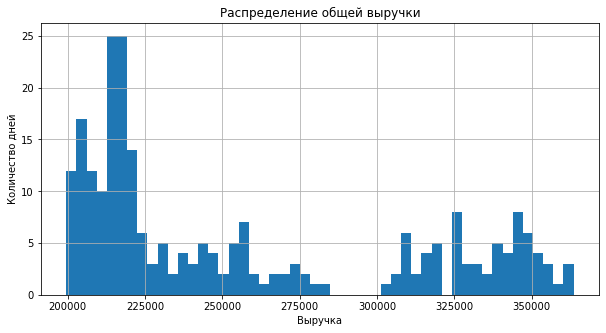

In [7]:
# суммарная выручка по всем филиалам

plt.figure(figsize=(10, 5))
plt.title('Распределение общей выручки') 
plt.xlabel('Выручка') 
plt.ylabel('Количество дней') 
plt.grid() 

plt.hist(data_revenue.groupby('date')['revenue'].sum(), bins=50) 

plt.show()


Видим, что в общей выручке явно есть смесь. Попробуем построить более детаельную гистограмму выручки без группирования по дню. 

Теперь за каждый день у нас будет 3 показателя за 1, 2 и 3 филиал.

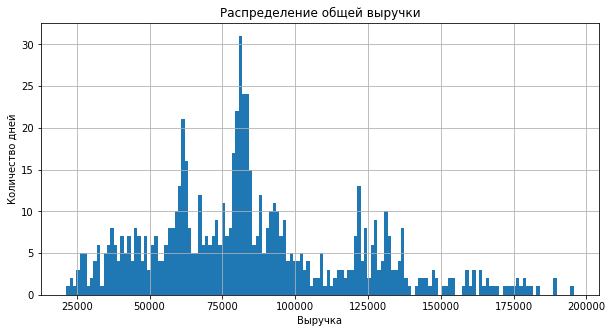

In [8]:
plt.figure(figsize=(10, 5)) 
plt.title('Распределение общей выручки') 
plt.xlabel('Выручка') 
plt.ylabel('Количество дней') 
plt.grid() 

plt.hist(data_revenue['revenue'], bins=150) # можем увеличить втрое количество бинов, чтобы визуализация была точнее

plt.show()

Очевидная смесь в данных. Посмотрим, решается ли это разделением на филиалы. Для этого построим гистограммы отдельно по филиалам 

с помощью метода `.unique` возьмем список уникальных филиалов и пройдем по нему циклом:

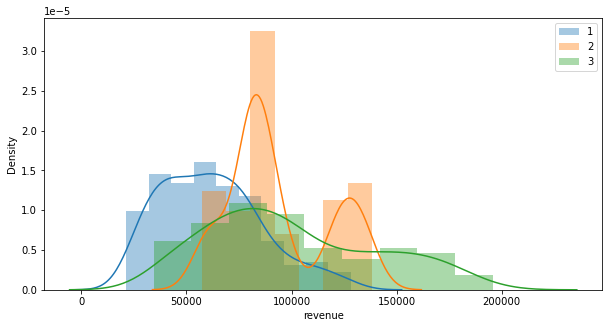

In [9]:
plt.figure(figsize=(10, 5)) 

filial = pd.unique(data_revenue['filial']) # сделаем серию со списком филиалов

for f in filial: # фильтр по филиалу
    sns.distplot(data_revenue.loc[data_revenue['filial'] == f]['revenue'], label = f);
    
plt.legend();

Как видим, во многом смесь объясняет разделение на филиалы, но не до конца.  
Посмотрим, как выглядят данные в виде временных рядов (в сумме и в разделении по филиалам)

### Отрисуем временной ряд

Используем объект `dates` из библиотеки `matplotlib`, чтобы управлять детальности отсечек по дате на оси графика.

В настройках графика мы укажем с помощью объекта `.MonthLocator()`, что хотим отображать даты по месяцам, а не по дням. 

- запишем в переменную `locator` месячную настройку подписей

- с помощью метода `.gca()` сообщим о намерении обратиться к конкретной оси `axis`, в нашем случае ось Х

- применим к оси метод `set_major_locator()` с месячной настройкой, которая лежит в переменной 


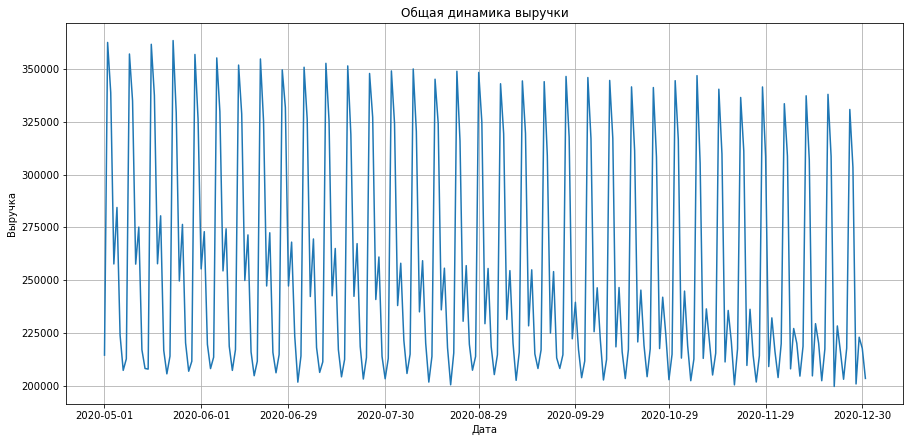

In [10]:
import matplotlib.dates as mdates #импортируем для локаторов

# суммарная выручка
plt.figure(figsize = (15, 7))

plt.title('Общая динамика выручки') 
plt.xlabel('Дата') 
plt.ylabel('Выручка') 
plt.grid()
locator = mdates.MonthLocator() # передадим, что хотим подписи помесячно
X = plt.gca().xaxis # обращаемся к оси х
X.set_major_locator(locator) # передадим в ось параметры локатора
sns.lineplot(x = data_revenue.groupby('date')['revenue'].sum().index, # .index, чтобы взять дату по оси x
             y = data_revenue.groupby('date')['revenue'].sum()
            )
plt.show()

И теперь проделаем то же самое для всех филиалов, используя цикл.

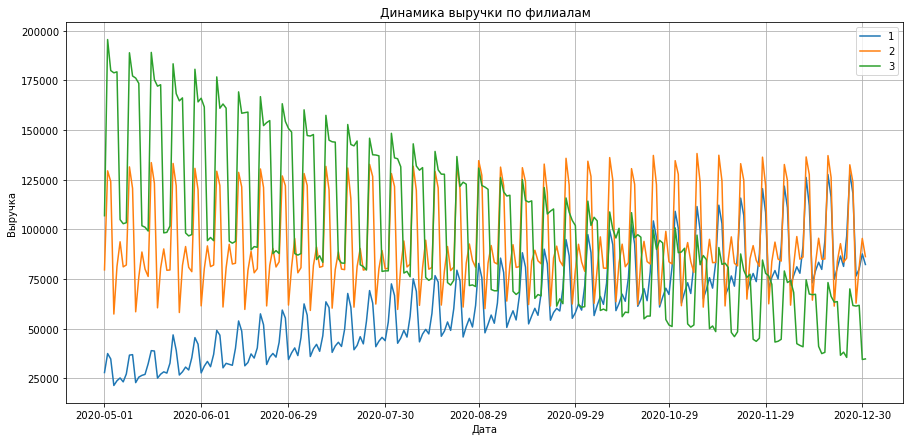

In [11]:
# выручка по филиалам
plt.figure(figsize = (15, 7))

plt.title('Динамика выручки по филиалам') 
plt.xlabel('Дата') 
plt.ylabel('Выручка') 
plt.grid()
for f in pd.unique(data_revenue['filial']):
    sns.lineplot( 
                 x = data_revenue.loc[data_revenue['filial'] == f]['date'], 
                 y = data_revenue.loc[data_revenue['filial'] == f]['revenue'], 
                 label = f);
    
locator = mdates.MonthLocator()
X = plt.gca().xaxis
X.set_major_locator(locator)

На основании графического анализа данных можно сделать следующие выводы и предположения:
- в данных есть смесь, вызванная тем, что разные филиалы в среднем имеют разную выручку
- в данных можно увидеть тренды (возрастающий тренд для филиалов 1 и 2 и убывающий тренд для филиала 3)
- в данных есть смесь, вызванная скорее сезонными явлениями (на это указывает циклический характер временных рядов)

Таким образом в качестве потенциальных гипотез, которые помогут улучшить качество прогнозной модели, стоит учесть:
- разделение по филиалам
- выделение линейного тренда
- добавление учета сезонности

# Построение прогнозной модели

Prophet — очень популярная библиотека от компании Facebook для анализа и прогнозирования временных рядов. 

__Посмотрим [документацию](https://facebook.github.io/prophet/docs/quick_start.html)__


Для построения модели нам нужно привести данные к стандартному виду, и нам понадобятся данные обучающей выборки.

### Обучающая/контрольная выборки 

Мы можем обучить нашу модель на данных с мая по ноябрь, а на декабрьских проверить, хорошо ли наша модель предсказывает. Разделим данные на обучающую и контрольную группы. 

<div style="display: flex; width: 100%; font-family: Arial">
<div style="width: 100%; margin-left: 0px">
  <div style="font-size: 20px; line-height: 30px">Обучающие данные</div>

  <div
    style="
      font-size: 14px;
      line-height: 20px;
      color: rgba(0, 0, 0, 0.48);
      margin-top: 16px;
    "
  >
    Основа для обучения модели. 
      <br/>
      Они выступают неким эталоном динамики и поведения данных.  
  </div>
</div>

<div style="width: 100%; margin-left: 24px">
  <div style="font-size: 20px; line-height: 30px">Контрольные данные</div>

  <div
    style="
      font-size: 14px;
      line-height: 20px;
      color: rgba(0, 0, 0, 0.48);
      margin-top: 16px;
    "
  >
    Нужны для проверки, как хорошо обучилась модель и на сколько точно она может предсказывать будущее. 
  </div>
</div>

<div style="width: 100%; margin-left: 24px">
  <div style="font-size: 20px; line-height: 30px">Переобучение модели</div>

  <div
    style="
      font-size: 14px;
      line-height: 20px;
      color: rgba(0, 0, 0, 0.48);
      margin-top: 16px;
    "
  >
    Ситуация, когда модель дает качество в обучении, но низкое на контроле, взяв единичные особенности обучающей выборки как общее поведение данных.
   
  </div>
</div>
</div>


<img style='float:left' src="https://raw.githubusercontent.com/foobar167/articles/master/Machine_Learning/Brochure/data/Ris2.6-Nedoobucheniye-optimum-i-pereobucheniye-v-regressii.png" width="700"/>

В нашем случае, как и договорились, разделим данные на обучение и контроль следующим образом:
- данные с мая по ноябрь — обучение
- данные за декабрь — контроль

In [12]:
train = data_revenue.loc[data_revenue['date'] < '2020-12-01']
test = data_revenue.loc[data_revenue['date'] >= '2020-12-01']

train.shape, test.shape

((642, 3), (93, 3))

### Попробуем построить первую модель для общей выручки

Для начала сгруппируем данные каждой выборки по дате с суммой выручки. Индекс сбросим, чтобы работать только с колонками.


In [13]:
train_0 = train.groupby(['date'])['revenue'].sum().reset_index() # сгруппировали данные обучающей выборки
test_0 = test.groupby(['date'])['revenue'].sum().reset_index() # сгруппировали данные контрольной выборки

In [14]:
train_0.head()

,date,revenue
0,2020-05-01,214440.127001
1,2020-05-02,362596.051865
2,2020-05-03,338862.717769
3,2020-05-04,257627.775214
4,2020-05-05,284399.010290


Установим и импортируем `Prophet()`. Несколько дополнительных способой установки можно найти в отдельном ноутбуке. 

In [15]:
# лучше pip не использовать и устанавливать через mamba, conda

# import sys
# !{sys.executable} -m pip install pystan

# import sys
# !{sys.executable} -m pip install prophet

In [16]:
from prophet import Prophet

Сначала попробуем построить прогнозную модель без указания каких бы то ни было параметров — пусть алгоритм действует на свое усмотрение.

Чтобы создать модель, мы используем 
1. объект `Prophet()` из библиотеки

2. метод `.fit()` для подгонки модели
3. правильно подготовленные данные


Создадим `model`, присвоив ей объект `Prophet()`

In [17]:
model = Prophet()
model

`.fit()` — метод подгонки модели под заданные данные и параметры модели

Нужно, чтобы в метод `.fit()` подавался датафрейм с нужными полями. Заглянем еще раз в [документацию.](https://facebook.github.io/prophet/docs/quick_start.html)
- `ds` — временная гранула, в нашем случае день

- `y` — значения, которые будем предсказывать, в нашем случае выручка

In [18]:
train_0.head()

,date,revenue
0,2020-05-01,214440.127001
1,2020-05-02,362596.051865
2,2020-05-03,338862.717769
3,2020-05-04,257627.775214
4,2020-05-05,284399.010290


Переименуем столбцы в обучающем и тестовом датасетах, чтобы они подходили для использования методов Prophet

In [19]:
train_0.columns = ['ds', 'y'] # переименовали столбцы

test_0.columns = ['ds', 'y']

In [20]:
model.fit(train_0) # подогнали модель под наши данные

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.99882
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       753.074   0.000547534       101.029       0.981       0.981      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       753.273   0.000180227        170.77   5.805e-07       0.001      206  LS failed, Hessian reset 
     181       753.376   2.41961e-07       62.3172       3e-09       0.001      327  LS failed, Hessian reset 
     185       753.376   3.16813e-08       63.5658      0.3168           1      333   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Как видим, алгоритм сам нам подсказывает, что он проигнорировал, выбирая параметры  

1. `INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.`

    - годовую сезонность (*для годовой сезонности нам нужно иметь данные минимум за два года, чтобы суметь использовать ее в модели*)


2. `INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.`

    - дневную сезонность (*дневная сезонность может использоваться в случае, если данные собираются по часам/минутам, в нашем случае данные представлены по дням*).


Зато он обнаружил недельную сезонность и использовал его при настройке модели.


## Качество модели

Посмотрим на качество получившейся модели. Для этого нам необходимо задать горизонт прогнозирования (в нашем случае это месяц) и создать дата-фрейм с датами из «будущего», для которого модель потом будет строить прогноз.

`make_future_dataframe()` — метод профета, который создает дата-фрейм с временным периодом будущего. В аргумент ему мы передаем `periods` и задаем количество элементов, на которые хотим получить прогноз. 

Так как наши данные имеют дневную гранулярность, прогноз мы также получим по дням от последней даты на количество дней, указанное в скобках.

In [21]:
future = model.make_future_dataframe(periods=31) # говорим профету сделать дата-фрейм на 31 день
future.tail(31) # выводим 31 строку с конца

,ds
214,2020-12-01
215,2020-12-02
216,2020-12-03
217,2020-12-04
218,2020-12-05
219,2020-12-06
220,2020-12-07
221,2020-12-08
222,2020-12-09
223,2020-12-10


Теперь можем построить прогноз методом __`.predict`__.

Применим его к нашей модели и запишем в отдельную переменную.

доверительный интервал по умолчанию 95%, это популярный стандарт, который вполне нас устраивает

In [22]:
forecast = model.predict(future)
forecast.head() # возвращает много колонок

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-05-01,268119.731895,216007.452882,233658.124281,268119.731895,268119.731895,-43330.048561,-43330.048561,-43330.048561,-43330.048561,-43330.048561,-43330.048561,0.0,0.0,0.0,224789.683334
1,2020-05-02,268014.000196,351325.396248,367530.987838,268014.000196,268014.000196,91772.913012,91772.913012,91772.913012,91772.913012,91772.913012,91772.913012,0.0,0.0,0.0,359786.913207
2,2020-05-03,267908.268496,323808.251598,339980.255582,267908.268496,267908.268496,64219.418953,64219.418953,64219.418953,64219.418953,64219.418953,64219.418953,0.0,0.0,0.0,332127.687449
3,2020-05-04,267802.536797,237057.730633,252913.066630,267802.536797,267802.536797,-22922.279050,-22922.279050,-22922.279050,-22922.279050,-22922.279050,-22922.279050,0.0,0.0,0.0,244880.257747
4,2020-05-05,267696.805098,261004.843710,278027.094813,267696.805098,267696.805098,1355.795067,1355.795067,1355.795067,1355.795067,1355.795067,1355.795067,0.0,0.0,0.0,269052.600165


Основные поля в прогнозе следующие:
- `ds` — дата прогноза

- `yhat` — спрогнозированное значение

- `yhat_lower` — нижняя граница доверительного интервала для прогноза
- `yhat_upper` — верхняя граница доверительного интервала для прогноза


In [23]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail() # оставим только нужные

,ds,yhat,yhat_lower,yhat_upper
240,2020-12-27,308090.666092,300280.424695,316226.383175
241,2020-12-28,220850.011487,212287.067726,229137.034743
242,2020-12-29,245029.129002,237107.694873,253704.660964
243,2020-12-30,204975.156387,196163.430076,212897.954032
244,2020-12-31,190978.842256,182900.786174,198974.398649


Также с помощью метода `.plot()` прогноз можно построить на графике и посмотреть визуально его адекватность.

Черные точки — наши данные.

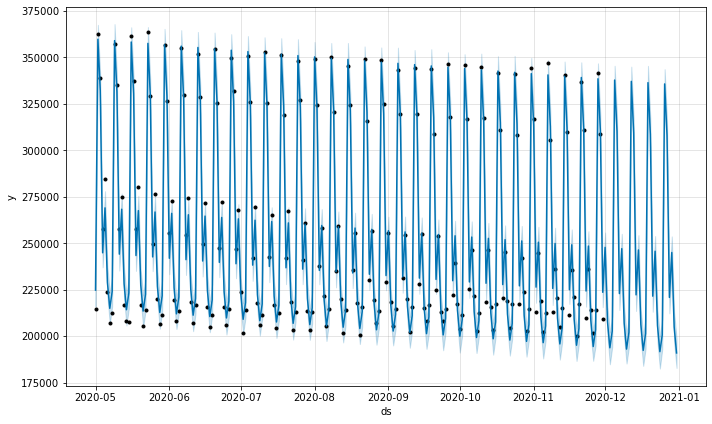

In [24]:
model.plot(forecast);

Кроме того, Prophet позволяет также наглядно разложить ряд на основные компоненты — тренд и сезонность:

`plot_components()` — возвращает несколько графиков, среди которых тренд и столько сезонностей, сколько он найдет.

Точка с запятой в конце строки позволяет не выводить лишнего. Обычно такая проблема возникает с графиками — выводится лишняя информация или даже дублирующиеся графики.

`Suppress output
Put a ‘;’ at the end of a line to suppress the printing of output. This is useful when doing calculations which generate long output you are not interested in seeing. It also keeps the object out of the output cache, so if you’re working with large temporary objects, they’ll be released from memory sooner.`

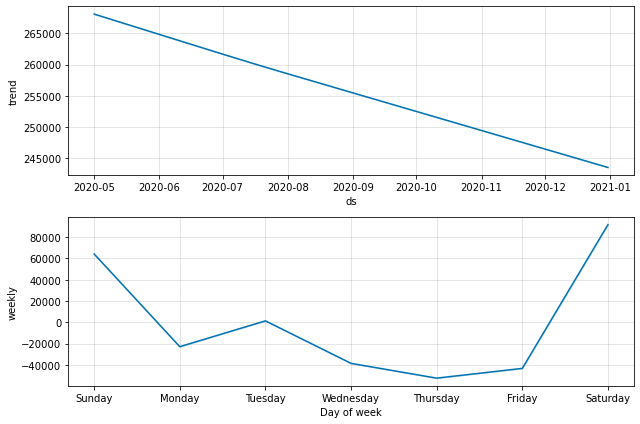

In [25]:
model.plot_components(forecast);

Видим, что тренд у общей выручки убывающий и у нас есть четкая недельная сезонность:
- наибольшее количество покупок люди совершают в субботу
- чуть меньше в воскресенье
- среди будних дней больше всего покупок в понедельник и вторник

## Ошибка прогноза

Посмотрим, какая получилась ошибка прогноза. По модели мы строим прогноз на тестовый период, затем сравниваем его с контрольными данными и считаем отклонение.

### Как посчитать отклонение?

Ошибку прогноза мы посчитаем с помощью функции `mean absolute error()` — среднее значение модулей отклонений прогноза от факта — из библиотеки **`scikit-learn`**:

В аргументы он принимает серию предсказанных значений и серию с контрольными значениями.  

Что под капотом у функции: из факта вычитаем прогноз, берем от этого модуль (положительное значение) и считаем среднее значение по всем модулям. 


In [26]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(forecast['yhat'].tail(31), test_0['y']) 

11817.737866588051

Сходу не понять, сильное ли отклонение мы получили. Посмотрим в %.

Для того чтобы посчитать `отклонение в процентах`, необходимо `модули отклонений прогноза от факта` разделить на `факт`, от полученных значений посчитать среднее арифметическое и умножить на 100.

`np.mean()` — функция библиотеки NumPy считает среднее арифметическое

`np.abs()` — функция библиотеки NumPy, которая вернет модули

In [27]:
modul_dif = np.abs(forecast.tail(31).reset_index()['yhat'] - test_0['y']) # положим модули отклонений от прогноза в отдельную переменную

dif = np.mean(modul_dif/test_0['y']) # считаем среднее арифметическое отклонение 

dif_percent = dif*100 # получаем процент

dif_percent

5.41044075806394

Или все то же самое можно записать в одну строку

In [28]:
np.mean(np.abs(forecast.tail(31).reset_index()['yhat'] - test_0['y'])/test_0['y'])*100

5.41044075806394

Попробуем теперь сделать такой же прогноз, но отдельно по филиалам и сравним результаты.  
Для начала подготовим данные отдельно по филиалам, сначала данные для обучения:

1. отфильтруем для каждого филиала нужные строки
2. переименуем столбцы для работы с `Prophet`

Мы переименовывали столбцы, меняя значения атрибута `columns`, теперь используем метод `rename()` — с ним вы тоже будете часто сталкиваться в чужом коде. Параметр `axis = 1` указывает, что переименовываем колонки.

In [29]:
train_1 = train.loc[train['filial'] == 1,['date','revenue']].rename({'date':'ds','revenue':'y'},axis=1) 
train_2 = train.loc[train['filial'] == 2,['date','revenue']].rename({'date':'ds','revenue':'y'},axis=1)
train_3 = train.loc[train['filial'] == 3,['date','revenue']].rename({'date':'ds','revenue':'y'},axis=1)

И то же самое проделаем для подготовки данных, чтобы проверить качества модели, только возьмем исходный тестовый датасет. В нем данные за декабрь. 

In [30]:
test_1 = test.loc[test['filial'] == 1,['date','revenue']].rename({'date':'ds','revenue':'y'},axis=1)
test_2 = test.loc[test['filial'] == 2,['date','revenue']].rename({'date':'ds','revenue':'y'},axis=1)
test_3 = test.loc[test['filial'] == 3,['date','revenue']].rename({'date':'ds','revenue':'y'},axis=1)

Теперь строим три модели по разным данным. Для каждой модели заведем переменную, так как нам нужны три разные модели.

1. Заведем 3 разные модели для 3 филиалов с помощью объекта `Prophet()`.
2. Передадим для каждой модели обучающий датасет в метод `fit()`, чтобы подогнать модель под наши данные.

In [31]:
m_1 = Prophet() # модель первого филиала
m_1.fit(train_1) # подгоняем модель под наши данные

# аналогичный код для двух других филиалов

m_2 = Prophet()
m_2.fit(train_2)

m_3 = Prophet()
m_3.fit(train_3)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.88166
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       635.394   0.000561797       197.313   4.266e-06       0.001      145  LS failed, Hessian reset 
      99       635.741    0.00229641       105.632           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       635.944   3.91895e-05       98.6593   4.199e-07       0.001      278  LS failed, Hessian reset 
     199       635.948   9.33142e-06       95.6777      0.5451      0.5451      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       636.133   2.25483e-07       73.5824           1           1      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       636.133   2.24565e-08       72.6548      0.2429      0.3638      452   
Optimization terminat

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.11738
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       814.169   0.000678077       78.4693           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       814.181   6.87493e-05       126.549   6.432e-07       0.001      174  LS failed, Hessian reset 
     143       814.243   5.51096e-05       117.766   4.695e-07       0.001      257  LS failed, Hessian reset 
     190       814.265   6.75678e-08       81.4378      0.2292           1      320   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.71245


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       611.797     0.0160736       110.623      0.7096           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       611.883    0.00161117       148.655   1.456e-05       0.001      157  LS failed, Hessian reset 
     152       612.824   0.000254904       97.5383   2.725e-06       0.001      251  LS failed, Hessian reset 
     199       612.896   1.07918e-05       98.0486           1           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       613.073   0.000497342       107.847   1.933e-06       0.001      409  LS failed, Hessian reset 
     299       613.187   5.72161e-07       103.515           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       613.187   1.56678e-08  

Теперь нам предстоит построить прогноз на тот же период для трех моделей.

Применим к каждой модели метод `predict()`, передав ему датасет с «будущими» датами.



In [32]:
forecast_1 = m_1.predict(future) # датасет с прогнозом для первого филиала
forecast_2 = m_2.predict(future) # датасет с прогнозом для второго филиала
forecast_3 = m_3.predict(future) # датасет с прогнозом для третьего филиала

      84.815       0.552       0.552      497   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Быстро визуализируем получившиеся данные

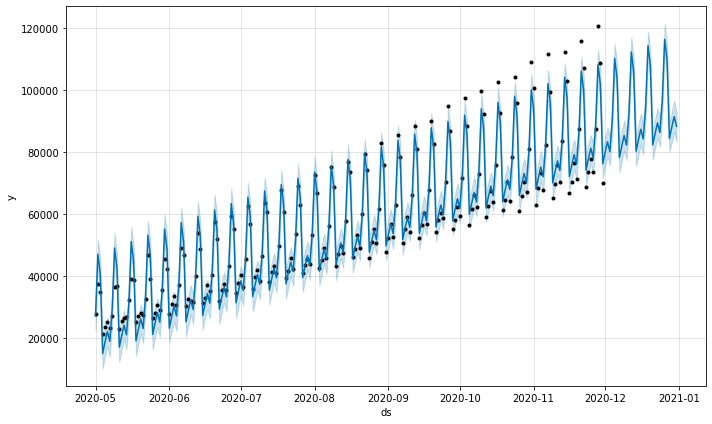

In [33]:
m_1.plot(forecast_1); 

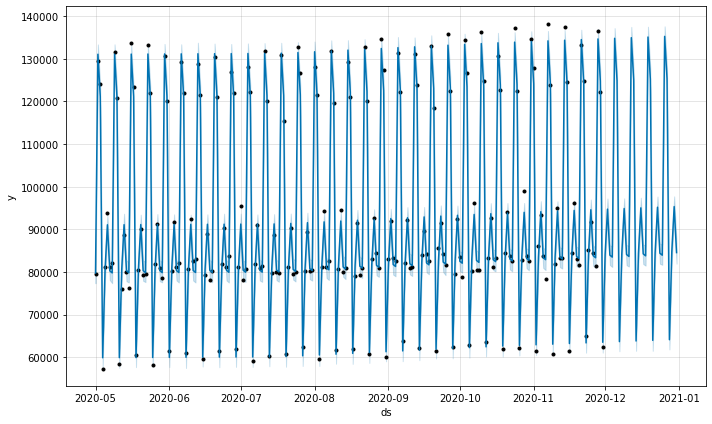

In [34]:
m_2.plot(forecast_2);

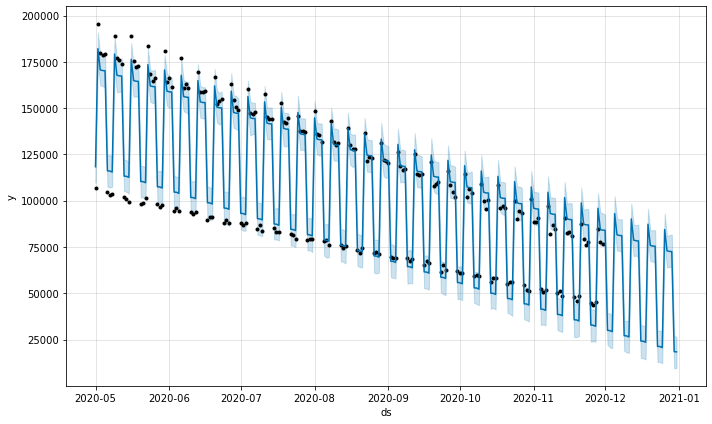

In [35]:
m_3.plot(forecast_3);

На графиках видно, что модель отдает слишком грубое предсказание. Попробуем скорректировать его с помощью более тонких настроек.

__Для начала посмотрим на ошибки отдельно для каждого филиала.__

Для этого для каждого филиала передадим в функцию `mean_absolute_error()` серию предсказанных значений и серию контрольных значений

In [36]:
error_forecast_1 = mean_absolute_error(forecast_1['yhat'].tail(31), test_1['y'])
error_forecast_2 = mean_absolute_error(forecast_2['yhat'].tail(31), test_2['y'])
error_forecast_3 = mean_absolute_error(forecast_3['yhat'].tail(31), test_3['y'])

error_forecast_1, error_forecast_2, error_forecast_3

(5857.707884843151, 1464.7683776440488, 13202.197461026099)

__Найдем процент ошибки для каждого филиала.__

Передадим в функцию `np.abs()` разницу между предсказанными данными и данными из тестовой выборки. Не забудем про `.reset_index()`.

Передадим в функцию `np.mean()` деление модулей разниц, которые получили только что, на данные тестовой выборки и умножим на 100, чтобы получить `%`.

In [37]:
modul_dif_1 = np.abs(forecast_1.tail(31).reset_index()['yhat'] - test_1.reset_index()['y'])
dif_percent_1 = np.mean(modul_dif_1/test_1.reset_index()['y'])*100

modul_dif_2 = np.abs(forecast_2.tail(31).reset_index()['yhat'] - test_2.reset_index()['y'])
dif_percent_2 = np.mean(modul_dif_2/test_2.reset_index()['y'])*100

modul_dif_3 = np.abs(forecast_3.tail(31).reset_index()['yhat'] - test_3.reset_index()['y'])
dif_percent_3 = np.mean(modul_dif_3/test_3.reset_index()['y'])*100

dif_percent_1, dif_percent_2, dif_percent_3

(6.29439716380751, 1.6137364453170253, 26.770344520478623)

В разных филиалах очень разный процент ошибки, давайте попробуем улучшить прогноз для первого и третьего филиалов.

## Настройка параметров модели

Мы запускали модель без параметров, давайте посмотрим, какие параметры модели можно задать. Рассмотрим основные:
- __`growth`__ — тренд 
    - `linear` — линейный, то есть данные растут или убывают равномерно
    
    - `logistic` — логистический сложносочиненный микс динамики данных
    
    
- __`holidays`__ — дата-фрейм с описанием праздников/выходных дней, чтобы они учитывались при построении прогноза


- __`seasonality`__ — сезонность

    - `weekly_seasonality` — недельная сезонность 

    - `daily_seasonality` — дневная сезонность 

    - `yearly_seasonality` — годовая сезонность 
    

- __`seasonality_mode`__ 
    - `multiplicative` — мультипликативная 
    - `additive` — аддитивная
    
Аддитивную сезонность имеет смысл использовать, если амплитуда колебаний сезонности из года в год не меняется. Если амплитуда колебаний сезонности из года в год меняется (т. е. размах уменьшается или увеличивается), то используем мультипликативную сезонность.

Вытащим тренд и обозначим, что у нас мультипликативная сезонность

In [38]:
m_1 = Prophet(growth = 'linear', weekly_seasonality = True, seasonality_mode='multiplicative')
m_1.fit(train_1)

m_2 = Prophet(growth = 'linear', weekly_seasonality = True, seasonality_mode='multiplicative')
m_2.fit(train_2)

m_3 = Prophet(growth = 'linear', weekly_seasonality = True, seasonality_mode='multiplicative')
m_3.fit(train_3)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.88166
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       953.878   0.000135362       136.444      0.6017      0.6017      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       954.204   5.61833e-05       126.779        1.25       0.125      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       954.303   6.33575e-06       60.8498     0.03131      0.4801      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     321       954.307   2.01924e-05       85.6462   2.599e-07       0.001      457  LS failed, Hessian reset 
     399       954.308   8.87409e-07       60.9763           1           1      558   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     484       954.378   9.35889e-06    

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.11738
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       816.278    0.00110988       96.7179      0.1758           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       816.837   5.99363e-06       85.8988      0.4156      0.4156      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227        816.84   8.64089e-06       65.5968   1.036e-07       0.001      339  LS failed, Hessian reset 
     262       816.841   4.34045e-08       80.7175       1.289      0.3601      383   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.71245


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       939.064   0.000784245       260.763           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       942.826    0.00112667       530.016      0.6245      0.6245      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282        944.88    0.00025928       417.666   2.639e-06       0.001      367  LS failed, Hessian reset 
     299       944.972   0.000331291       280.904       0.378       0.378      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       945.899   3.00018e-05       146.269   7.507e-08       0.001      537  LS failed, Hessian reset 
     384        946.73   1.66137e-05       122.939   1.209e-07       0.001      629  LS failed, Hessian reset 
     399       946.841   1.69859e-05  

In [39]:
forecast_1 = m_1.predict(future)
forecast_2 = m_2.predict(future)
forecast_3 = m_3.predict(future)

__Сравним ошибки__

В модели без параметров ошибки были: 
- 6270.750421944441
- 1627.752566953797
- 13210.181303922529

In [40]:
error_forecast_1 = mean_absolute_error(forecast_1['yhat'].tail(31), test_1['y'])
error_forecast_2 = mean_absolute_error(forecast_2['yhat'].tail(31), test_2['y'])
error_forecast_3 = mean_absolute_error(forecast_3['yhat'].tail(31), test_3['y'])

error_forecast_1, error_forecast_2, error_forecast_3

(716.2944297382618, 1432.6959439469938, 1139.2844462242103)

__И посчитаем в процентах, так гораздо надежнее__ 

Напомню, что было:
- 6.7900069525078095
- 1.7779055372059944
- 26.902829147537332

In [41]:
modul_dif_1 = np.abs(forecast_1.tail(31).reset_index()['yhat'] - test_1.reset_index()['y'])
dif_percent_1 = np.mean(modul_dif_1/test_1.reset_index()['y'])*100

modul_dif_2 = np.abs(forecast_2.tail(31).reset_index()['yhat'] - test_2.reset_index()['y'])
dif_percent_2 = np.mean(modul_dif_2/test_2.reset_index()['y'])*100

modul_dif_3 = np.abs(forecast_3.tail(31).reset_index()['yhat'] - test_3.reset_index()['y'])
dif_percent_3 = np.mean(modul_dif_3/test_3.reset_index()['y'])*100

dif_percent_1, dif_percent_2, dif_percent_3

(0.7796994669869148, 1.5484083440318366, 2.1108439622900836)

In [42]:
# хотя, датасайнтисты запишут скорее так:

np.mean(np.abs(forecast_1.tail(31).reset_index()['yhat'] - test_1.reset_index()['y'])/test_1.reset_index()['y'])*100, \
np.mean(np.abs(forecast_2.tail(31).reset_index()['yhat'] - test_2.reset_index()['y'])/test_2.reset_index()['y'])*100, \
np.mean(np.abs(forecast_3.tail(31).reset_index()['yhat'] - test_3.reset_index()['y'])/test_3.reset_index()['y'])*100

(0.7796994669869148, 1.5484083440318366, 2.1108439622900836)

Теперь даже если мы сложим наши ожидаемые ошибки по трем филиалам, увидим, что общий прогноз стал гораздо точнее.

In [43]:
f1 = forecast_1.tail(31).reset_index()['yhat']
f2 = forecast_2.tail(31).reset_index()['yhat']
f3 = forecast_3.tail(31).reset_index()['yhat']

total_forecast = f1 + f2 + f3

mean_absolute_error(total_forecast, test_0['y'])

1934.1062800062336

Теперь, когда модель выбрана, надо перестроить модель по всему набору данных и сделать прогноз на январь:

In [44]:
# готовим данные с мая по декабрь

data_revenue_1 = data_revenue.loc[data_revenue['filial'] == 1].drop('filial', axis=1).rename({'date':'ds','revenue':'y'},axis=1)
data_revenue_2 = data_revenue.loc[data_revenue['filial'] == 2].drop('filial', axis=1).rename({'date':'ds','revenue':'y'},axis=1)
data_revenue_3 = data_revenue.loc[data_revenue['filial'] == 3,['date','revenue']].rename({'date':'ds','revenue':'y'},axis=1)

# обучаем модель

m_1 = Prophet(growth = 'linear', weekly_seasonality = True, seasonality_mode='multiplicative')
m_1.fit(data_revenue_1)

m_2 = Prophet(growth = 'linear', weekly_seasonality = True, seasonality_mode='multiplicative')
m_2.fit(data_revenue_2)

m_3 = Prophet(growth = 'linear', weekly_seasonality = True, seasonality_mode='multiplicative')
m_3.fit(data_revenue_3)

# создаем дата-фрейм на январь

future = m_1.make_future_dataframe(periods=31) # говорим профету сделать дата-фрейм на 31 день

# наполняем январь данными для каждого филиала

forecast_1 = m_1.predict(future)
forecast_2 = m_2.predict(future)
forecast_3 = m_3.predict(future)



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.75899
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1106.42    8.2903e-05       119.167      0.3241           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1106.95   0.000168101       127.412      0.9803      0.9803      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       1107.05   9.46159e-09       53.9237     0.01749     0.01749      351   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.26867
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       937.644    0.00231307       106.802           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       938.102   1.90571e-07       67.3527      0.2012           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       938.102    1.4883e-08       70.2859      0.1004      0.3879      272   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.40664
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1080.49    0.00214585       495.508           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    


Теперь мы хотим объединить данные по филиалам. Тут нам мог бы пригодиться `merge()`, но вспомним, что мы можем объединять только 2 таблицы, то есть придется делать две операции объединения. А если в таблице одинаковые колонки, то мы можем просто сложить дата-фреймы.

Чтобы воспользоваться этой суперспособностью дата-фреймов, нам нужно, чтобы дата оказалась в индексе, ведь даты в `pandas` не складываются.

In [45]:
# складываем выручку на каждый день по всем 3 филиалам

f1 = forecast_1.tail(31)[['ds','yhat']].set_index('ds')
f2 = forecast_2.tail(31)[['ds','yhat']].set_index('ds')
f3 = forecast_3.tail(31)[['ds','yhat']].set_index('ds')

total_forecast = (f1 + f2 + f3)

In [46]:
total_forecast.head()

,yhat
ds,
2021-01-01,217020.504507
2021-01-02,332608.211022
2021-01-03,305634.558200
2021-01-04,198793.953633
2021-01-05,224949.608159


Возьмем только нужные столбцы и переименуем их для заказчика.

In [47]:
total_forecast.reset_index(inplace=True)
total_forecast[['ds', 'yhat']]
total_forecast.columns = ['date', 'revenue']

Выгрузим данные в таблицу.

In [48]:
total_forecast.head()

,date,revenue
0,2021-01-01,217020.504507
1,2021-01-02,332608.211022
2,2021-01-03,305634.558200
3,2021-01-04,198793.953633
4,2021-01-05,224949.608159


In [49]:
total_forecast.to_csv('forecast_jan2021.csv')